# Results

In [1]:
import sys
sys.path.append("../utils/")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
plt.rcParams['font.sans-serif'] = 'Arial'


In [ ]:
def objective(L : np.ndarray, S):
    lmbda = 1 / np.sqrt(np.max(L.shape))
    f = np.linalg.norm(L, ord='nuc') + lmbda * np.abs(S).sum()
    return f


In [3]:
Image = {}
Image[0] = plt.imread('../data/1.jpeg')
Image[1] = plt.imread('../data/2.jpg')
Image[2] = plt.imread('../data/3.jpg')

method_rpca = ["CGD", "ALM", "SVT", "APG"]
method_mc = ["ADMM", "SVT", "PMF", "BPMF"]

Image_recon = {}
# Image_recon[0]

## PCA

In [ ]:
time_log = {}
rank_log = {}
norm_log = {}
obj_log = {}
for i in range(3):
    img = Image[i] / 255
    img_noise = util.random_noise(img, mode='s&p', seed=2022)
    L = {}
    S = {}
    rank = [1, 2, 3, 5, 10, 50]
    for j in range(len(rank)):
        start = time.time()
        r = rank[j]
        for k in range(3):
            U, D, V = np.linalg.svd(img_noise[:,:,k], full_matrices=False)
            D[r:] = 0
            L[k] = U @ np.diag(D) @ V
            S[k] = img_noise[:,:,k] - L[k]
        img_recon = np.dstack([L[m] for m in range(3)])
        noise = np.dstack([S[m] for m in range(3)])
        np.save(f'../data/img_recon_{i}_pca_r{j}', img_recon)
        np.save(f'../data/noise_{i}_pca_r{j}', noise)
        end = time.time()
        time_log[f'img_{i}_PCA_r{j}'] = end - start
        rank_log[f'img_{i}_PCA_r{j}'] = np.mean([np.linalg.matrix_rank(img_recon[:,:,n]) for n in range(3)])
        norm_log[f'img_{i}_PCA_r{j}'] = np.sum(np.abs(noise) > 1e-20) / 3
        obj_log[f'img_{i}_PCA_r{j}'] = np.mean([objective(img_recon[:,:,n], noise[:,:,n]) for n in range(3)])


In [ ]:
keys = np.array(list(time_log.keys()))
img_num = [keys[i][4] for i in range(len(keys))]
alg = [keys[i].split('_', 2)[-1] for i in range(len(keys))]
log = pd.DataFrame(alg, index=img_num, columns=['Algorithm'])
log['Time (s)'] = time_log.values()
log['$rank(\ml)$'] = rank_log.values()
log['$\|\ms\|_0$'] = norm_log.values()
log['$\|\ml\|_{*}$'] = obj_log.values()
log.to_csv('../data/results_pca.csv', float_format='%.1f')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

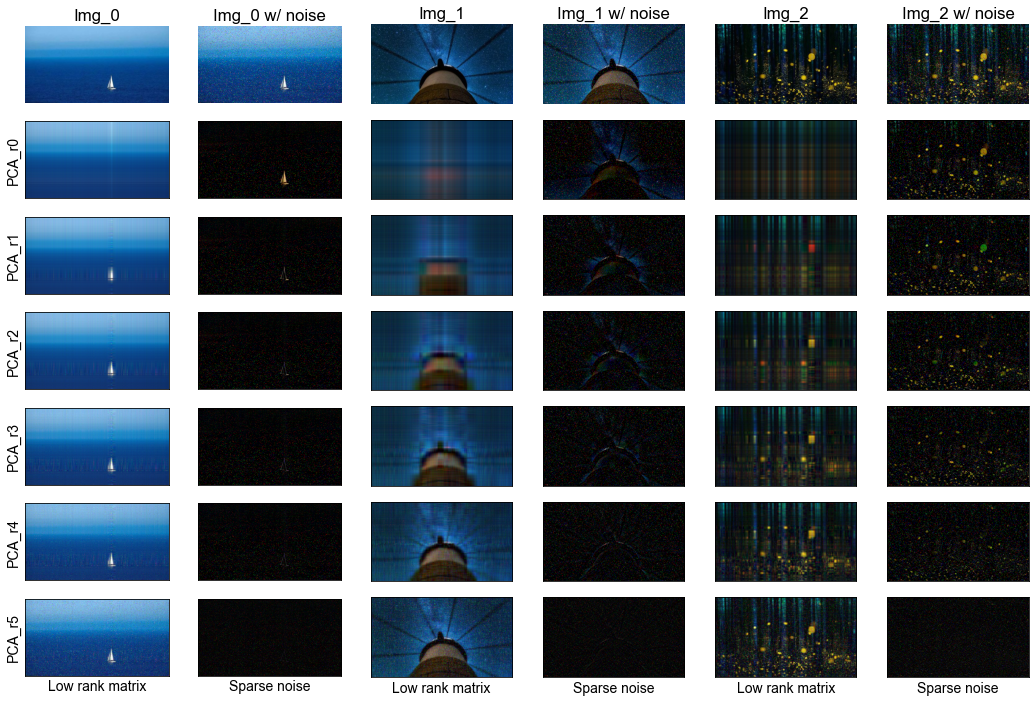

In [29]:
n_rows = 7
n_cols = 6
adj = 2
plt.figure(figsize=(18, 12))
for i in range(3):
    j = 0
    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 1)
    plt.imshow(Image[i])
    plt.axis('off')
    plt.title(f'Img_{i}')

    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 2)
    noise = np.load(f'../data/img_noise_{i}_rpca.npy')
    plt.imshow(noise)
    plt.title(f'Img_{i} w/ noise')
    plt.axis('off')

    for k in range(6):
        j += 1
        plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 1)
        img = np.load(f'../data/img_recon_{i}_pca_r{k}.npy')
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        if i == 0: plt.ylabel(f'PCA_r{k}')
        if k == 5: plt.xlabel('Low rank matrix')

        plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 2)
        noise = np.load(f'../data/noise_{i}_pca_r{k}.npy')
        plt.imshow(noise)
        plt.xticks([])
        plt.yticks([])
        if k == 5: plt.xlabel('Sparse noise')

plt.savefig('../doc/figures/pca_total.pdf', bbox_inches='tight', pad_inches=0.01)
plt.show()


## Robust PCA

In [ ]:
time_log = np.load('../data/time_log.npy', allow_pickle=True).item()
rank_log = {}
norm_log = {}
obj_log = {}
for key in time_log.keys():
    img_path = '../data/img_recon' + key.lstrip('img') + '.npy'
    noise_path = '../data/noise' + key.lstrip('img') + '.npy'
    img_recon = np.load(img_path)
    noise = np.load(noise_path)
    rank_log[key] = np.mean([np.linalg.matrix_rank(img_recon[:,:,i]) for i in range(3)])
    norm_log[key] = np.sum(np.abs(noise) > 1e-20) / 3
    if 'rpca' in key:
        obj_log[key] = np.mean([objective(img_recon[:,:,i], noise[:,:,i]) for i in range(3)])
    else:
        obj_log[key] = np.mean([np.linalg.norm(img_recon[:,:,i], ord='nuc') for i in range(3)])


In [ ]:
for i in range(3):
    img_corrupted = np.moveaxis(np.load(f'../data/corrupted_{i}.npy'), 0, -1)
    img_recon = np.moveaxis(np.load(f'../data/imputed_img_exact_{i}.npy'), 0, -1)
    img_recon_pro = np.moveaxis(np.load(f'../data/imputed_img_{i}.npy'), 0, -1)
    rank_log[f'img_{i}_mc_CNTK'] = np.mean([np.linalg.matrix_rank(img_recon[:,:,i]) for i in range(3)])
    rank_log[f'img_{i}_mc_CNTK_EigenPro'] = np.mean([np.linalg.matrix_rank(img_recon_pro[:,:,i]) for i in range(3)])
    norm_log[f'img_{i}_mc_CNTK'] = np.sum(np.abs(img_corrupted - img_recon) > 1e-20) / 3
    norm_log[f'img_{i}_mc_CNTK_EigenPro'] = np.sum(np.abs(img_corrupted - img_recon_pro) > 1e-20) / 3
    obj_log[f'img_{i}_mc_CNTK'] = np.mean([np.linalg.norm(img_recon[:,:,i], ord='nuc') for i in range(3)])
    obj_log[f'img_{i}_mc_CNTK_EigenPro'] = np.mean([np.linalg.norm(img_recon_pro[:,:,i], ord='nuc') for i in range(3)])
    time_log[f'img_{i}_mc_CNTK'] = 340.658810377121
    time_log[f'img_{i}_mc_CNTK_EigenPro'] = 69.06


In [ ]:
keys = np.array(list(time_log.keys()))
img_num = [keys[i][4] for i in range(len(keys))]
alg = [keys[i].split('_', 3)[-1] for i in range(len(keys))]
log = pd.DataFrame(alg, index=img_num, columns=['Algorithm'])
log['Time (s)'] = time_log.values()
log['$rank(\ml)$'] = rank_log.values()
log['$\|\ms\|_0$'] = norm_log.values()
log['$\|\ml\|_{*}$'] = obj_log.values()
mc_idx = ['mc' in keys[i] for i in range(log.shape[0])]
rpca_idx = ['rpca' in keys[i] for i in range(log.shape[0])]

log[rpca_idx].to_csv('../data/results_rpca.csv', float_format='%.1f')
log[mc_idx].to_csv('../data/results_mc.csv', float_format='%.1f')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

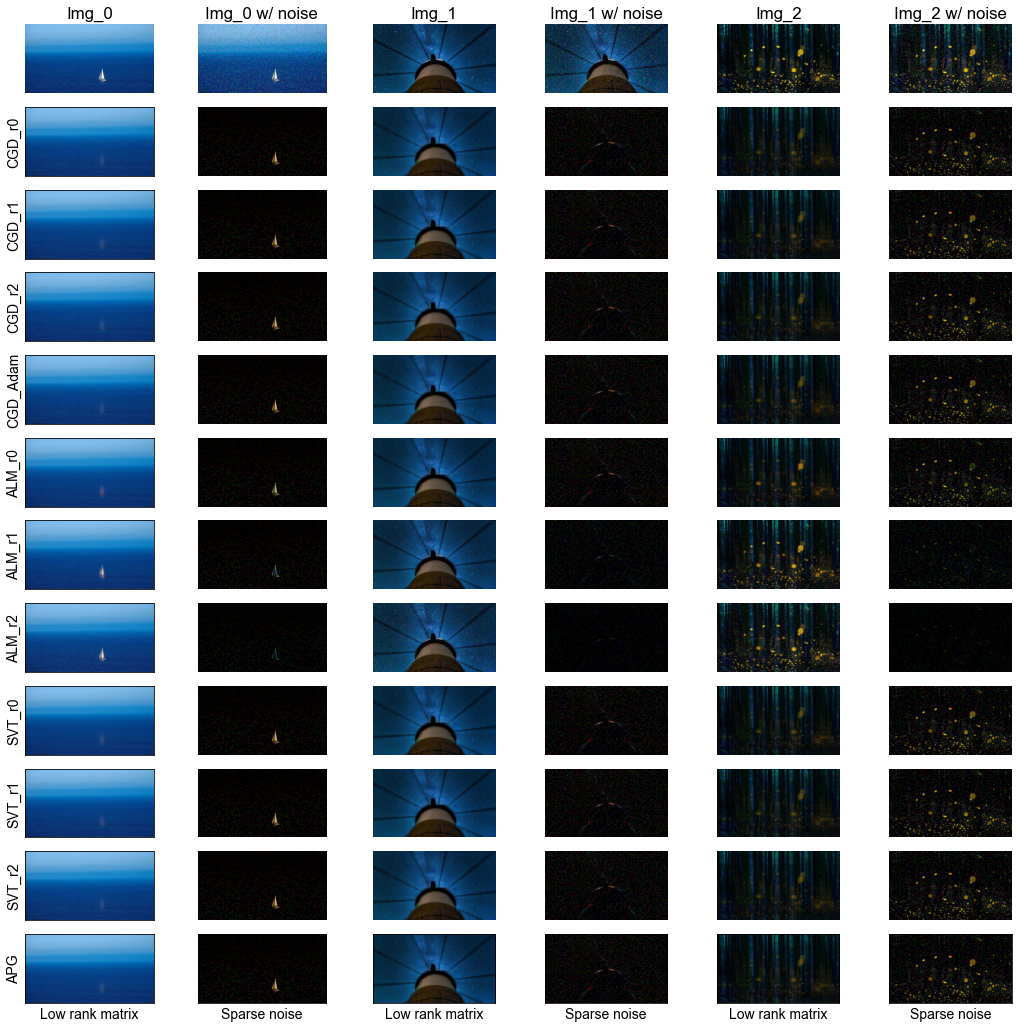

In [18]:
n_rows = 12
n_cols = 6
adj = 2
plt.figure(figsize=(18, 18))
for i in range(3):
    j = 0
    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 1)
    plt.imshow(Image[i])
    plt.axis('off')
    plt.title(f'Img_{i}')

    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 2)
    noise = np.load(f'../data/img_noise_{i}_rpca.npy')
    plt.imshow(noise)
    plt.title(f'Img_{i} w/ noise')
    plt.axis('off')

    for k in range(3):
        j += 1
        plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 1)
        img = np.load(f'../data/img_recon_{i}_rpca_{method_rpca[0]}_r{k}.npy')
        plt.imshow(img)
        if i == 0:
            plt.xticks([])
            plt.yticks([])
            plt.ylabel(f'{method_rpca[0]}_r{k}')
        else:
            plt.axis('off')

        plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 2)
        noise = np.load(f'../data/noise_{i}_rpca_{method_rpca[0]}_r{k}.npy')
        plt.imshow(noise)
        plt.axis('off')

    j += 1
    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 1)
    img = np.load(f'../data/img_recon_{i}_rpca_{method_rpca[0]}_Adam.npy')
    plt.imshow(img)
    if i == 0:
        plt.xticks([])
        plt.yticks([])
        plt.ylabel(f'{method_rpca[0]}_Adam')
    else:
        plt.axis('off')

    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 2)
    noise = np.load(f'../data/noise_{i}_rpca_{method_rpca[0]}_Adam.npy')
    plt.imshow(noise)
    plt.axis('off')

    for k in range(3):
        j += 1
        plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 1)
        img = np.load(f'../data/img_recon_{i}_rpca_{method_rpca[1]}_r{k}.npy')
        plt.imshow(img)
        if i == 0:
            plt.xticks([])
            plt.yticks([])
            plt.ylabel(f'{method_rpca[1]}_r{k}')
        else:
            plt.axis('off')

        plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 2)
        noise = np.load(f'../data/noise_{i}_rpca_{method_rpca[1]}_r{k}.npy')
        plt.imshow(noise)
        plt.axis('off')

    for k in range(3):
        j += 1
        plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 1)
        img = np.load(f'../data/img_recon_{i}_rpca_{method_rpca[2]}_r{k}.npy')
        plt.imshow(img)
        if i == 0:
            plt.xticks([])
            plt.yticks([])
            plt.ylabel(f'{method_rpca[2]}_r{k}')
        else:
            plt.axis('off')

        plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 2)
        noise = np.load(f'../data/noise_{i}_rpca_{method_rpca[2]}_r{k}.npy')
        plt.imshow(noise)
        plt.axis('off')
        
    j += 1
    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 1)
    img = np.load(f'../data/img_recon_{i}_rpca_{method_rpca[3]}.npy')
    plt.imshow(img)
    if i == 0:
        plt.xticks([])
        plt.yticks([])
        plt.ylabel(f'{method_rpca[3]}')
        plt.xlabel('Low rank matrix')
    else:
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('Low rank matrix')

    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 2)
    noise = np.load(f'../data/noise_{i}_rpca_{method_rpca[3]}.npy')
    plt.imshow(noise)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Sparse noise')

# plt.savefig('../doc/figures/robust_pca_total.pdf', bbox_inches='tight', pad_inches=0.01)
plt.show()


## Matrix Completion

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

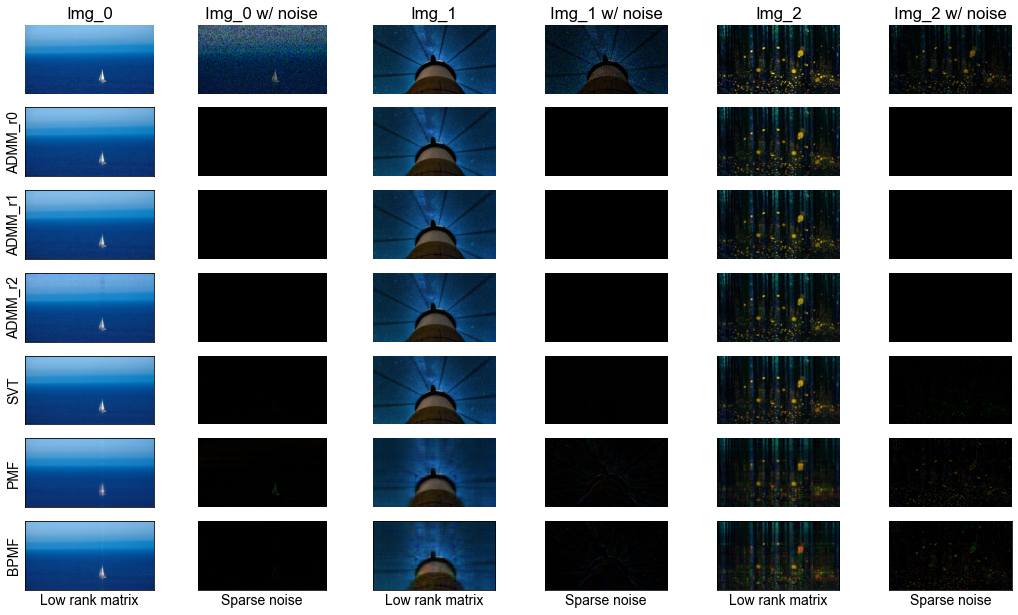

In [6]:
n_rows = 12
n_cols = 6
adj = 2
plt.figure(figsize=(18, 18))
for i in range(3):
    j = 0
    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 1)
    plt.imshow(Image[i])
    plt.axis('off')
    plt.title(f'Img_{i}')

    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 2)
    noise = np.load(f'../data/img_noise_{i}_mc.npy')
    plt.imshow(noise)
    plt.title(f'Img_{i} w/ noise')
    plt.axis('off')

    for k in range(3):
        j += 1
        plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 1)
        img = np.load(f'../data/img_recon_{i}_mc_{method_mc[0]}_r{k}.npy')
        plt.imshow(img)
        if i == 0:
            plt.xticks([])
            plt.yticks([])
            plt.ylabel(f'{method_mc[0]}_r{k}')
        else:
            plt.axis('off')

        plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 2)
        noise = np.load(f'../data/noise_{i}_mc_{method_mc[0]}_r{k}.npy')
        plt.imshow(noise)
        plt.axis('off')

    j += 1
    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 1)
    img = np.load(f'../data/img_recon_{i}_mc_{method_mc[1]}.npy')
    plt.imshow(img)
    if i == 0:
        plt.xticks([])
        plt.yticks([])
        plt.ylabel(f'{method_mc[1]}')
    else:
        plt.axis('off')

    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 2)
    noise = np.load(f'../data/noise_{i}_mc_{method_mc[1]}.npy')
    plt.imshow(noise)
    plt.axis('off')

    j += 1
    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 1)
    img = np.load(f'../data/img_recon_{i}_mc_{method_mc[2]}.npy')
    plt.imshow(img)
    if i == 0:
        plt.xticks([])
        plt.yticks([])
        plt.ylabel(f'{method_mc[2]}')
    else:
        plt.axis('off')

    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 2)
    noise = np.load(f'../data/noise_{i}_mc_{method_mc[2]}.npy')
    plt.imshow(noise)
    plt.axis('off')

    j += 1
    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 1)
    img = np.load(f'../data/img_recon_{i}_mc_{method_mc[3]}.npy')
    plt.imshow(img)
    if i == 0:
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('Low rank matrix')
        plt.ylabel(f'{method_mc[3]}')
    else:
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('Low rank matrix')

    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 2)
    noise = np.load(f'../data/noise_{i}_mc_{method_mc[3]}.npy')
    plt.imshow(noise)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Sparse noise')

# plt.savefig('../doc/figures/matrix_completion.pdf', bbox_inches='tight', pad_inches=0.01)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

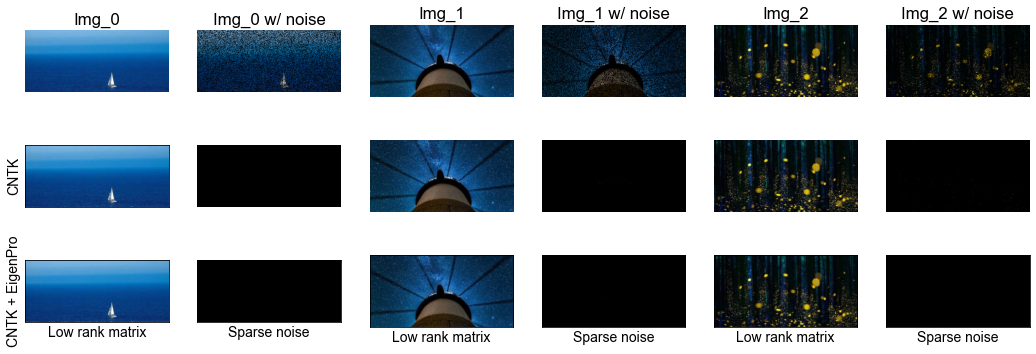

In [7]:
n_rows = 3
n_cols = 6
adj = 2
plt.figure(figsize=(18, 6))
for i in range(3):
    j = 0
    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 1)
    img_clean = np.moveaxis(np.load(f'../data/clean_{i}.npy'), 0, -1)
    plt.imshow(img_clean)
    plt.axis('off')
    plt.title(f'Img_{i}')

    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 2)
    img_corrupted = np.moveaxis(np.load(f'../data/corrupted_{i}.npy'), 0, -1)
    plt.imshow(img_corrupted)
    plt.title(f'Img_{i} w/ noise')
    plt.axis('off')

    j += 1
    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 1)
    img = np.moveaxis(np.load(f'../data/imputed_img_exact_{i}.npy'), 0, -1)
    plt.imshow(img)
    if i == 0:
        plt.xticks([])
        plt.yticks([])
        plt.ylabel('CNTK')
    else:
        plt.axis('off')

    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 2)
    plt.imshow(img_corrupted - img)
    plt.axis('off')

    j += 1
    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 1)
    img = np.moveaxis(np.load(f'../data/imputed_img_{i}.npy'), 0, -1)
    plt.imshow(img)
    if i == 0:
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('Low rank matrix')
        plt.ylabel('CNTK + EigenPro')
    else:
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('Low rank matrix')

    plt.subplot(n_rows, n_cols, j * n_cols + adj * i + 2)
    plt.imshow(img_corrupted - img)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Sparse noise')

# plt.savefig('../doc/figures/matrix_completion_ntk.pdf', bbox_inches='tight', pad_inches=0.01)
plt.show()
